# D2. ENSEMBLE METHODS : BAGGING WITHOUT OUTLIERS

__2.1 Importing Libraries and Datasets__

__2.2 Bagging Regressor__

__2.3 Model Evaluation : Training Mertrics__

__2.4 Model Evaluation : Cross Validation__

__2.5 Model Evaluation : Test Dataset__

__2.6 Feature Importances__

__2.7 Residuals' Distribution__

__2.8 Scatterplots with fitted line (Train Dataset)__

__2.9 Saving Results__

## 2.1 Importing Libraries and Datasets

In [1]:
# Libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import StandardScaler

import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', 100)

In [2]:
# Train Dataset

train_data = pd.read_csv("BG_Train_Dataset_No_Outliers.csv") 
train_df = train_data.copy()
train_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.321,4.427,1.574,5.794,8.838,1,1,1,2,129


In [3]:
# Test Dataset

test_data = pd.read_csv("BG_Test_Dataset_No_Outliers.csv") 
test_df = test_data.copy()
test_df.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA,Post Operative Glucose
0,3.728,5.596,0.0,7.543,8.058,0,0,2,2,115


## 2.2 Bagging Regressor

In [4]:
# Defining X_train and Y_train

Y_train = train_df['Post Operative Glucose']
X_train = train_df.drop('Post Operative Glucose', axis = 1)
X_train.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.321,4.427,1.574,5.794,8.838,1,1,1,2


In [5]:
# Using the KFold function for cross-validation

cv = KFold(n_splits = 5, shuffle = True, random_state = 126)

In [6]:
# Defining Grid for Hyperparameter Tuning - LR

grid_LR = {'base_estimator': [LinearRegression()], 
        'n_estimators': [10,20,30,40,50,80,100],
        'max_samples': np.arange(0.1,1,0.1),
        'max_features': np.arange(0.1,1,0.1),
        'bootstrap': [True, False],
        'bootstrap_features': [True, False]}

In [7]:
## Defining Grid for Hyperparameter Tuning - DTR

grid_DTR = {'base_estimator': [DecisionTreeRegressor()], 
        'n_estimators': [20,40,60],
        'max_samples': np.arange(0.2,0.6,0.2),
        'max_features': np.arange(0.15, 0.45, 0.15),
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        # DTR hyperparameters
       'base_estimator__max_depth': [4,8,None],
        'base_estimator__min_samples_split': [4,6,8],
        'base_estimator__min_samples_leaf': [4,6,8],
        'base_estimator__max_leaf_nodes' : [6,8,10]}

In [8]:
# Instantiating GridSearchCV 

Bagging_search_LR = GridSearchCV(BaggingRegressor(random_state = 126), 
                            grid_LR, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, verbose = 1)

Bagging_search_DTR = GridSearchCV(BaggingRegressor(random_state = 126), 
                            grid_DTR, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, verbose = 1)

In [9]:
# Searching for the best parameters for Bagging - LR

CV_Bagging_results_LR = Bagging_search_LR.fit(X_train, Y_train)

Fitting 5 folds for each of 2268 candidates, totalling 11340 fits


In [10]:
# Searching for the best parameters for Bagging - DTR

CV_Bagging_results_DTR = Bagging_search_DTR.fit(X_train, Y_train)

Fitting 5 folds for each of 5832 candidates, totalling 29160 fits


In [11]:
# Displaying the best parameters - LR

Bagging_Best_Parameters_LR = pd.DataFrame(CV_Bagging_results_LR.best_params_,
                                       index = ['Best Bagging Regressor Parameters-LR'])

Bagging_Best_Parameters_LR = Bagging_Best_Parameters_LR.transpose()
Bagging_Best_Parameters_LR

,Best Bagging Regressor Parameters-LR
base_estimator,LinearRegression()
bootstrap,False
bootstrap_features,False
max_features,0.9
max_samples,0.4
n_estimators,20


In [12]:
# Displaying the best parameters - DTR

Bagging_Best_Parameters_DTR = pd.DataFrame(CV_Bagging_results_DTR.best_params_,
                                       index = ['Best Bagging Regressor Parameters-DTR'])

Bagging_Best_Parameters_DTR = Bagging_Best_Parameters_DTR.transpose()
Bagging_Best_Parameters_DTR

,Best Bagging Regressor Parameters-DTR
base_estimator,DecisionTreeRegressor()
base_estimator__max_depth,8
base_estimator__max_leaf_nodes,10
base_estimator__min_samples_leaf,4
base_estimator__min_samples_split,4
bootstrap,True
bootstrap_features,False
max_features,0.45
max_samples,0.4
n_estimators,40


In [13]:
# Storing the values of the best parameters - DTR

best_estimator_DTR = CV_Bagging_results_DTR.best_params_['base_estimator']
best_n_estimators_DTR = CV_Bagging_results_DTR.best_params_['n_estimators']
best_max_samples_DTR = CV_Bagging_results_DTR.best_params_['max_samples']
best_max_features_DTR = CV_Bagging_results_DTR.best_params_['max_features']
best_bootstrap_DTR = CV_Bagging_results_DTR.best_params_['bootstrap']
best_bootstrap_features_DTR = CV_Bagging_results_DTR.best_params_['bootstrap_features']

# Parameters of DTR
best_base_estimator__max_depth = CV_Bagging_results_DTR.best_params_['base_estimator__max_depth']
best_base_estimator__max_leaf_nodes = CV_Bagging_results_DTR.best_params_['base_estimator__max_leaf_nodes']
best_base_estimator__min_samples_leaf = CV_Bagging_results_DTR.best_params_['base_estimator__min_samples_leaf']
best_base_estimator__min_samples_split = CV_Bagging_results_DTR.best_params_['base_estimator__min_samples_split']

In [14]:
# Instantiating the best Bagging Model-LR

BaggingModel_LR = BaggingRegressor(**CV_Bagging_results_LR.best_params_, random_state = 126).fit(X_train,Y_train)
BaggingModel_LR

BaggingRegressor(base_estimator=LinearRegression(), bootstrap=False,
                 max_features=0.9, max_samples=0.4, n_estimators=20,
                 random_state=126)

In [15]:
# Instantianting the best DTR
best_estimator_DTR = DecisionTreeRegressor(max_depth = best_base_estimator__max_depth,
                                        max_leaf_nodes = best_base_estimator__max_leaf_nodes,
                                        min_samples_leaf = best_base_estimator__min_samples_leaf,
                                       min_samples_split = best_base_estimator__min_samples_split)


# Instantiating the best Bagging Model-DTR

BaggingModel_DTR = BaggingRegressor(random_state = 126,
                                 base_estimator = best_estimator_DTR,
                                 n_estimators = best_n_estimators_DTR, 
                                 max_samples = best_max_samples_DTR, 
                                 max_features = best_max_features_DTR,
                                 bootstrap = best_bootstrap_DTR,
                                 bootstrap_features = best_bootstrap_features_DTR).fit(X_train,Y_train)


BaggingModel_DTR

BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=8,
                                                      max_leaf_nodes=10,
                                                      min_samples_leaf=4,
                                                      min_samples_split=4),
                 max_features=0.44999999999999996, max_samples=0.4,
                 n_estimators=40, random_state=126)

In [16]:
# Function that calculates the cross validated test MAE   

def cv_scores(X,Y, model,cv):
        
    cv_MAE = round(np.mean(cross_val_score(model, X, Y, cv=cv, 
                                       scoring='neg_mean_absolute_error', 
                                           error_score='raise') * (-1)),2)
    
    score = cv_MAE
    return score

In [17]:
# Calculating the cross-validated scores of each model

Score_of_LR = cv_scores(X_train,Y_train, BaggingModel_LR,cv)
Score_of_DTR = cv_scores(X_train,Y_train, BaggingModel_DTR,cv)

# The final Bagging Model is the one with the small MAE
if Score_of_LR < Score_of_DTR:
    BaggingModel = BaggingModel_LR
else:
    BaggingModel = BaggingModel_DTR

In [18]:
# The final Bagging model
BaggingModel

BaggingRegressor(base_estimator=LinearRegression(), bootstrap=False,
                 max_features=0.9, max_samples=0.4, n_estimators=20,
                 random_state=126)

## 2.3 Model Evaluation : Training Mertrics

In [19]:
# Getting the R^2

Bagging_R2 = np.round(BaggingModel.score(X_train,Y_train),3)

In [20]:
# Getting predictions and training metrics 

BaggingPredictions = BaggingModel.predict(X_train)
BaggingFeats = BaggingModel.n_features_in_
Bagging_Tr_MAE = np.round(mean_absolute_error(Y_train, BaggingPredictions),3)

In [21]:
# Dictionary the holds the information of  R^2, number of predictors and training metrics

dict1 = {'Bagging Regressor' : [Bagging_R2, BaggingFeats, Bagging_Tr_MAE]}

In [22]:
# Creating a dataframe to easily present the results 

Training_metric_df = pd.DataFrame(dict1, index=['R^2','Num_of_Feats','Tr_MAE'])

In [23]:
# Displaying the training evaluation metrics

Training_metric_df

,Bagging Regressor
R^2,0.472
Num_of_Feats,9.000
Tr_MAE,15.322


## 2.4 Model Evaluation : Cross Validation

In [24]:
# Dictionary that holds the information of the cross validated test MAE 

dict2 = {'Bagging Regressor':cv_scores(X_train,Y_train, BaggingModel,cv)}

In [25]:
# Creating a dataframe to easily present the results 

Test_CV_results = pd.DataFrame(dict2, index=['Te_MAE (KFold)'])

# Displaying the cross validated test error results

Test_CV_results

,Bagging Regressor
Te_MAE (KFold),15.94


## 2.5 Model Evaluation : Test Dataset

In [26]:
# Defining X_test and Y_test

Y_test = test_df['Post Operative Glucose']
X_test = test_df.drop('Post Operative Glucose', axis = 1)
X_test.head(1)

,Age,BMI,Smoking,Pre Operative Fast,Pre Operative Glucose,Sex,Cort,LV,ASA
0,3.728,5.596,0.0,7.543,8.058,0,0,2,2


In [27]:
# Getting predictions

Bagging_predictions = BaggingModel.predict(X_test)

In [28]:
# Getting Test Metrics

Bagging_Te_MAE = round(mean_absolute_error(Y_test, Bagging_predictions),2)

In [29]:
# Dictionary that holds the information of test MAE  

dict3 = {'Bagging Regressor':[Bagging_Te_MAE]}

In [30]:
# Creating a dataframe to easily present the results 

Test_Dat_results = pd.DataFrame(dict3, index=['Te_MAE'])

In [31]:
# Displaying the test error results

Test_Dat_results

,Bagging Regressor
Te_MAE,19.01


## 2.6 Feature Importances

In [32]:
# load JS visualization code to notebook

shap.initjs()

In [33]:
# Instantiating and fitting the best model 

model = BaggingModel
# model.fit(X_train, Y_train);

In [34]:
# Creating the explainer

explainer = shap.KernelExplainer(model.predict, X_train);

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [35]:
# Calculate Shapley values for the data

shap_values = explainer(X_train)

  0%|          | 0/200 [00:00<?, ?it/s]

In [36]:
# Picking a color for the graphs

color = 'orange'

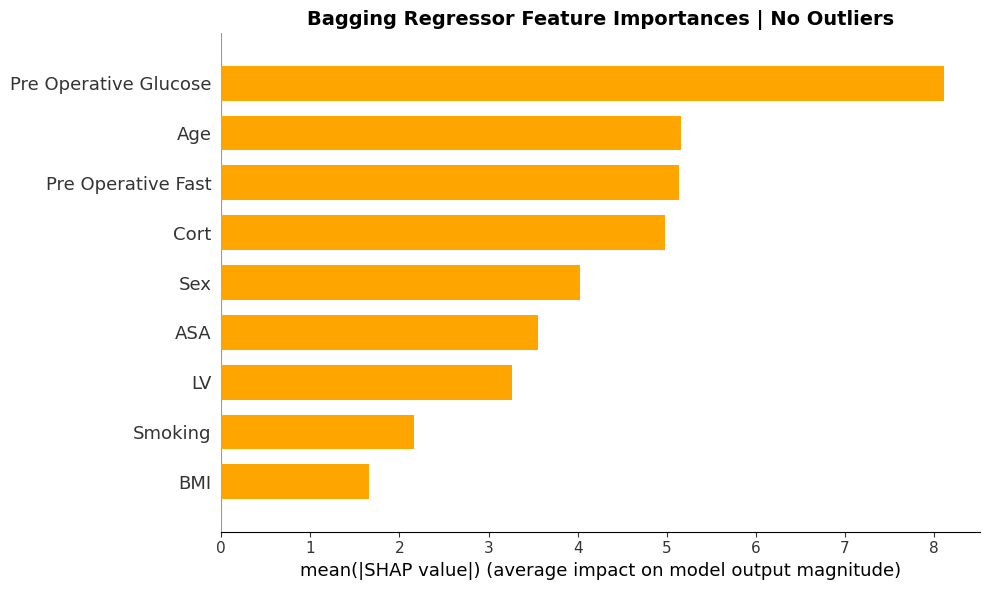

In [37]:
# Plot summary plot to visualize feature importance

plt.title(label = "Bagging Regressor Feature Importances | No Outliers" , fontsize = 14, weight = 'bold')

shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, 
                  plot_type='bar', 
                  color=color, plot_size= (10,6))

plt.show()

## 2.7 Residuals' Distribution

In [38]:
# Models' fitted values

fitted_y1 = BaggingPredictions

# Models' residuals

residuals1 = Y_train - BaggingPredictions

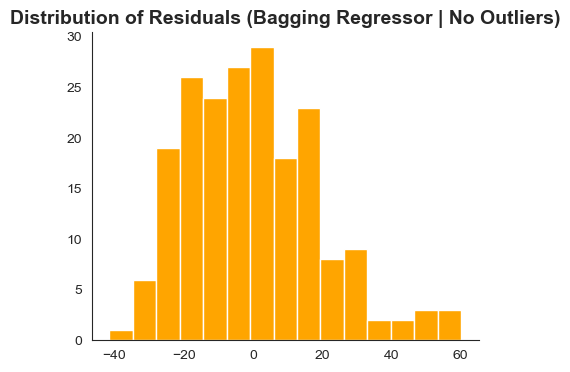

In [39]:
# Histogram of residuals 

sns.set_style("white")
    
plt.figure(figsize=(5,4))
    
plt.hist(residuals1, bins = 15, color = color)
    
plt.title(label = "Distribution of Residuals (Bagging Regressor | No Outliers)" , fontsize = 14, weight = 'bold')
    
sns.despine()
    
plt.show()

## 2.8 Scatterplots with fitted line (Train Dataset)

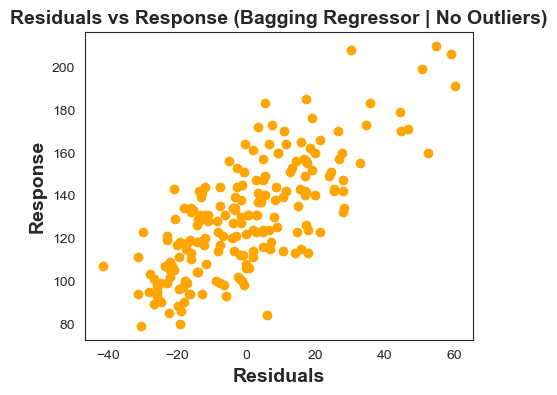

In [40]:
# Plotting residuals vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(residuals1, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(residuals1, Y_train, 1)

# plt.plot(residuals1, b*residuals1 + a, color = 'black')

plt.title(label = 'Residuals vs Response (Bagging Regressor | No Outliers)', fontsize = 14, weight = 'bold')
plt.xlabel('Residuals',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')

plt.show()

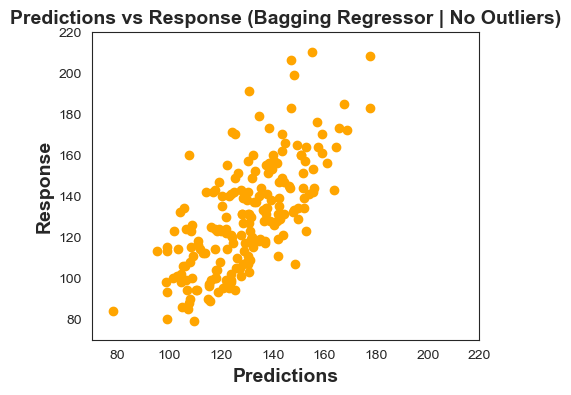

In [41]:
# Plotting predictions vs response 

sns.set_style("white")

plt.figure(figsize=(5,4))

plt.plot(BaggingPredictions, Y_train, 'o', color = color)

# Uncomment the following lines to add a fitted line
# b,a = np.polyfit(BaggingPredictions, Y_train, 1)

# plt.plot(BaggingPredictions, b*BaggingPredictions + a, color = 'black')

plt.title(label = 'Predictions vs Response (Bagging Regressor | No Outliers)', fontsize = 14, weight = 'bold')
plt.xlabel('Predictions',fontsize = 14, weight = 'bold')
plt.ylabel('Response',fontsize = 14, weight = 'bold')


plt.xlim(70, 220)
plt.ylim(70, 220)


plt.show()

## 2.9 Saving Results 

In [42]:
# Concatenating the training and test Dataframes

BaggingResults = pd.concat([Training_metric_df, Test_CV_results, Test_Dat_results], axis =  0)
BaggingResults

,Bagging Regressor
R^2,0.472
Num_of_Feats,9.000
Tr_MAE,15.322
Te_MAE (KFold),15.940
Te_MAE,19.010


In [43]:
# Saving the Results

BaggingResults.to_csv(r'BaggingResultsNoOutliers.csv', index=True, index_label = 'Metric')